In [1]:
pip install pydmd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.5/169.5 kB 2.8 MB/s eta 0:00:00


**Dynamic mode decomposition with control**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

from pydmd import DMDc
from pydmd.plotter import plot_eigs

Creamos nuestro conjunto de datos: como queremos agregar el control, la evolución del sistema complejo se puede resumir formalmente como:

image.png

donde los operadores A y B son los que aproximaremos usando DMDc. Entonces, con fines demostrativos, creamos las instantáneas originales utilizando dos operadores aleatorios.



In [3]:
def create_system(n, m):
    A = scipy.linalg.helmert(n, True)
    B = np.random.rand(n, n) - 0.5
    x0 = np.array([0.25] * n)
    u = np.random.rand(n, m - 1) - 0.5
    snapshots = [x0]
    for i in range(m - 1):
        snapshots.append(A.dot(snapshots[i]) + B.dot(u[:, i]))
    snapshots = np.array(snapshots).T
    return {"snapshots": snapshots, "u": u, "B": B, "A": A}

In [4]:
s = create_system(25, 10)
print(s["snapshots"].shape)

(25, 10)


Ahora, podemos calcular como de costumbre el algoritmo DMD sobre los datos: el método de ajuste en esta versión toma como argumentos las instantáneas y la entrada de control. En este caso, no realizamos ningún truncamiento.

In [5]:
dmdc = DMDc(svd_rank=-1)
dmdc.fit(s["snapshots"], s["u"])

Visualicemos el sistema original y el reconstruido:

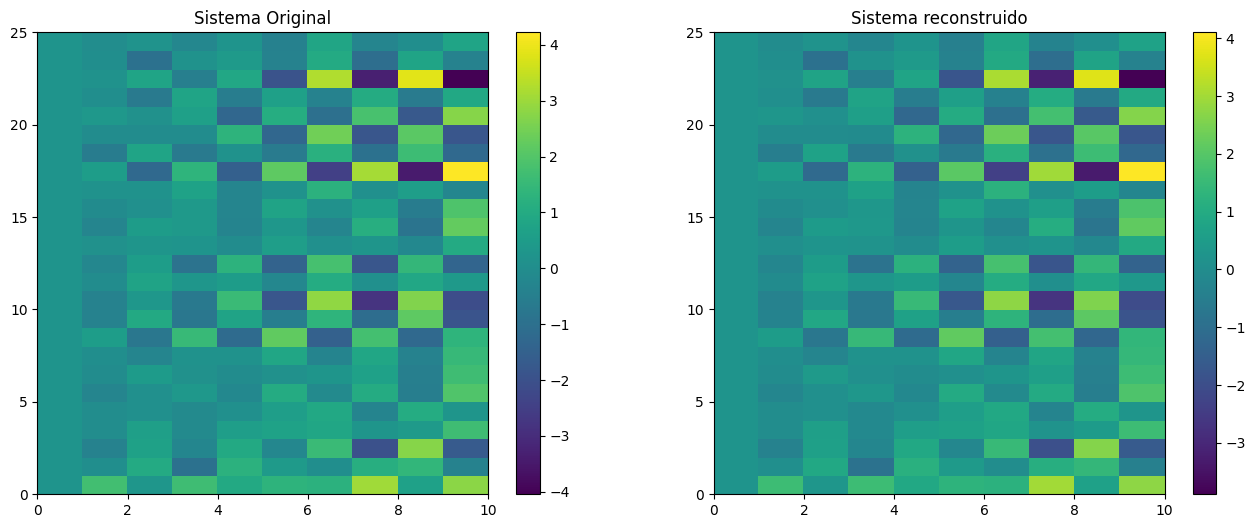

In [7]:

plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.title("Sistema Original")
plt.pcolor(s["snapshots"].real)
plt.colorbar()

plt.subplot(122)
plt.title("Sistema reconstruido")
plt.pcolor(dmdc.reconstructed_data().real)
plt.colorbar()

plt.show()

**Recuperando dinámicas inestables**

En el siguiente ejemplo de DMDc vamos a investigar el efecto estabilizador del control en un sistema lineal inestable. Por simplicidad, consideramos un sistema 2D con un operador B conocido. Este ejemplo coincide con el ejemplo 1 del artículo: [Dynamic mode decomposition with control](https://arxiv.org/abs/1409.6358)

In [16]:
time_instants = 5

A = np.array([[1.5, 0], [0, 0.1]])
B = np.array([1, 0])[:, None]

snapshots = np.zeros((2, time_instants))
snapshots[:, 0] = np.array([4, 7])

In [17]:
for i in range(1, time_instants):
    previous_snapshot = snapshots[:, i - 1][:, None]
    snapshots[:, i] = (
        A.dot(previous_snapshot) - B * previous_snapshot
    ).flatten()
print(snapshots)

[[4.0e+00 2.0e+00 1.0e+00 5.0e-01 2.5e-01]
 [7.0e+00 7.0e-01 7.0e-02 7.0e-03 7.0e-04]]


In [18]:
I = snapshots[:, :-1]
print(I)

dmdc = DMDc(svd_rank=-1).fit(snapshots, I, np.diag(B.flatten()))

[[4.    2.    1.    0.5  ]
 [7.    0.7   0.07  0.007]]


Si analizamos el sistema resultante del conjunto de instantáneas, como si no supiéramos que se trata de un sistema de control. Por lo tanto, utilizamos el algoritmo DMD estándar y luego trazamos los valores propios para evaluar la estabilidad de su dinámica.

/usr/local/lib/python3.10/dist-packages/pydmd/plotter.py:195: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(


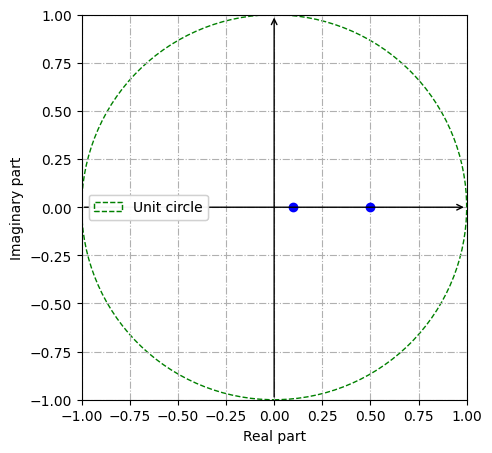

In [19]:
from pydmd import DMD

dmd = DMD(svd_rank=-1)
dmd.fit(snapshots)
plot_eigs(
    dmd,
    show_axes=True,
    show_unit_circle=True,
    figsize=(5, 5),
    filename="eigs_ex1.pdf",
)

Como podemos ver, todos los autovalores están dentro de la esfera unitaria, por lo tanto, las dinámicas correspondientes son todas estables.

Por el contrario, si usamos DMDc vemos que hay algunas dinámicas inestables en el operador A "real", que perdemos cuando usamos el algoritmo original, pero que se recuperan si empleamos el modificado.

/usr/local/lib/python3.10/dist-packages/pydmd/plotter.py:195: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(


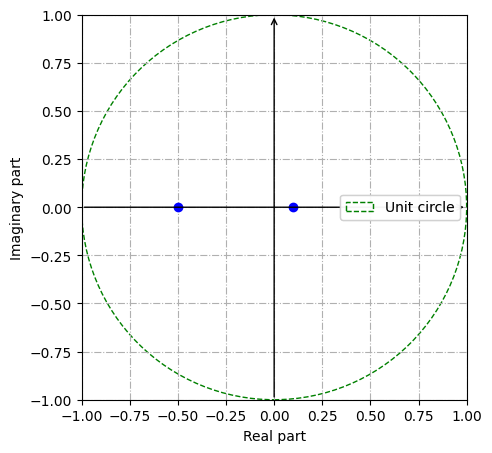

In [20]:
plot_eigs(dmdc, show_axes=True, show_unit_circle=True, figsize=(5, 5))

Buscamos una confirmación de este hecho calculando los valores propios del operador A que usamos cuando construimos el sistema, y ​​los comparamos con los valores propios de dmd.atilde que contiene la aproximación de A construida por DMD con control.

In [21]:
print(
    "Eigenvalues of A:",
    np.linalg.eigvals(A),
    "; eigenvalues of A_tilde: ",
    np.linalg.eigvals(dmdc.operator.as_numpy_array),
)


Eigenvalues of A: [1.5 0.1] ; eigenvalues of A_tilde:  [ 0.1 -0.5]
